# Imports

In [1]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares, UnbinnedNLL, BinnedNLL, ExtendedUnbinnedNLL
except:
  Exception('Error Initialising Iminuit')

In [2]:
import os
from IPython.display import Latex
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from funcs import *
from stats import *
from Fit import *

/home/banana33/Documents/Lab2/Circuiti_3/Fit.py:87: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(_x_range, self.model(_x_range, **self.values), label=f'fit \n $\chi^2$ = {round(self.fval/self.ndof, 2)}', color='red')


# Functions

In [31]:
def analize(path, init=0, verbose=False)->tuple:
    '''
    `path`: path to the data file
    `init`: initial guess for the maximum
    `verbose`: if True, returns all the data, if False, returns only the relevant data
    `return`: tuple with the relevant data as follows:
        V_CH1_SGN, V_MTH_SGN, dt_CH1_SGN, dt_MTH_SGN
    '''
    CH1, SGN, MTH = get_data(path)
    N = init

    max_CH1, i_max_CH1 = find_max(CH1[1], N, prec=0.00001)
    max_SGN, i_max_SGN = find_max(SGN[1], N, prec=0.00001)
    max_MTH, i_max_MTH = find_max(MTH[1], N, prec=0.00001)
    z, i_zero_CH1 = find_zero(CH1[1], N, prec=0.00001)
    z, i_zero_SGN = find_zero(SGN[1], N, prec=0.00001)
    z, i_zero_MTH = find_zero(MTH[1], N, prec=0.00001)

    V_CH1_SGN = max_CH1/max_SGN
    V_MTH_SGN = max_MTH/max_SGN

    zero_CH1 = (CH1[0][i_zero_CH1]+CH1[0][i_zero_CH1+1])/2
    zero_SGN = (SGN[0][i_zero_SGN]+SGN[0][i_zero_SGN+1])/2
    zero_MTH = (MTH[0][i_zero_MTH]+MTH[0][i_zero_MTH+1])/2

    dt_CH1_SGN = np.abs(zero_CH1 - zero_SGN)
    dt_MTH_SGN = np.abs(zero_MTH - zero_SGN)

    if verbose:
        return CH1,SGN,MTH, V_CH1_SGN, V_MTH_SGN, dt_CH1_SGN, dt_MTH_SGN, max_CH1, max_SGN, max_MTH, zero_CH1, zero_SGN, zero_MTH, i_max_CH1, i_max_SGN, i_max_MTH, i_zero_CH1, i_zero_SGN, i_zero_MTH
    
    else:
        return V_CH1_SGN, V_MTH_SGN, dt_CH1_SGN, dt_MTH_SGN


# RC

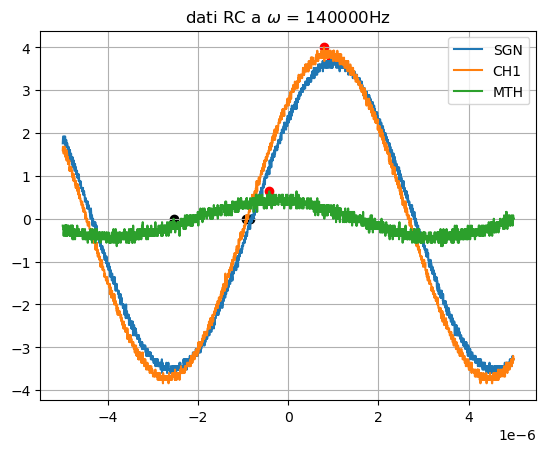

In [4]:
path = 'data/RC/140000/'
CH1,SGN,MTH, V_CH1_SGN, V_MTH_SGN, dt_CH1_SGN, dt_MTH_SGN, max_CH1, max_SGN, max_MTH, zero_CH1, zero_SGN, zero_MTH, i_max_CH1, i_max_SGN, i_max_MTH, i_zero_CH1, i_zero_SGN, i_zero_MTH = analize(path, 200, True)

plt.plot(SGN[0], SGN[1], label='SGN')
plt.plot(CH1[0], CH1[1], label='CH1')
plt.plot(MTH[0], MTH[1], label='MTH')
plt.scatter(CH1[0][i_max_CH1], max_CH1, color='red')
plt.scatter(MTH[0][i_max_MTH], max_MTH, color='red')
plt.scatter(CH1[0][i_zero_CH1], zero_CH1, color='k')
plt.scatter(SGN[0][i_zero_SGN], zero_SGN, color='k')
plt.scatter(MTH[0][i_zero_MTH], zero_MTH, color='k')
plt.scatter(SGN[0][i_max_SGN], 3.76, color='r')
plt.title(r"dati RC a $\omega$ = 140000Hz")
plt.grid()
plt.legend()

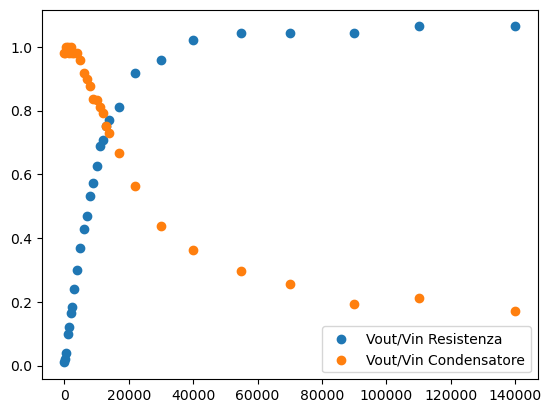

In [36]:
V_res_all, dt_res_all, freqs = [], [], []
V_c_all, dt_c_all = [], []

for i in os.listdir('data/RC'):
    path = 'data/RC/'+i+'/'
    V_CH1_RES, V_C_SGN, dt_RES_SGN, dt_C_SGN = analize(path, 300, False)
    V_res_all.append(V_CH1_RES)
    V_c_all.append(V_C_SGN)
    dt_res_all.append(dt_RES_SGN*float(i))
    dt_c_all.append(dt_C_SGN*float(i))
    freqs.append(float(i))

freqs = np.array(freqs)
V_res_all = np.array(V_res_all)
plt.scatter(freqs,V_res_all, label='Vout/Vin Resistenza')
plt.scatter(freqs,V_c_all, label='Vout/Vin Condensatore')
plt.legend()

In [38]:
def H_R(w,tau, a):
    return w*tau/np.sqrt(1+(w**2 * tau**2)) + a

1.3002607636171124


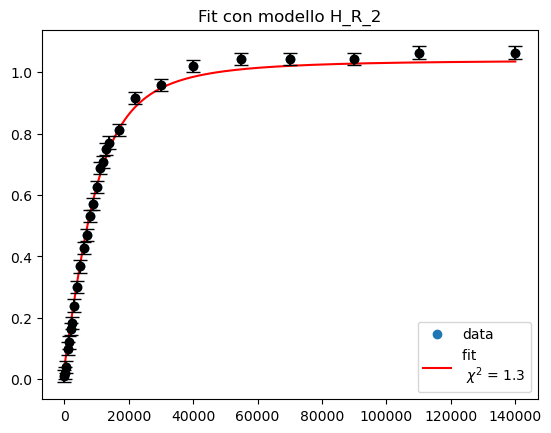

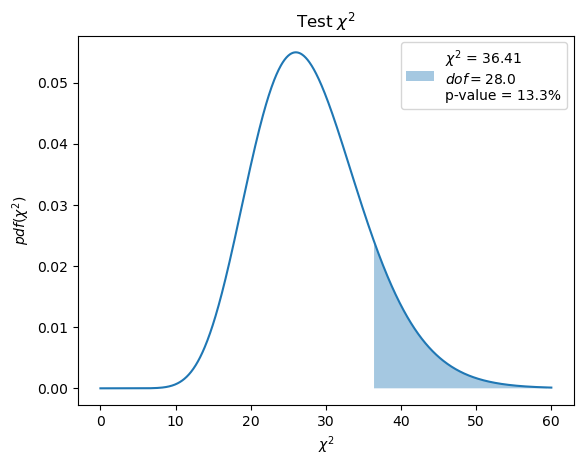

In [39]:
f = Fit(freqs, V_res_all, H_R, 0.02, kwargs={'tau':1e-3, 'a':0.07})
popt, pcov = f.fit(scipy=True)

f.fit(scipy=True)
fig, ax = f.visualize()
print(f.fval / f.ndof)
plt.legend()
plt.title('Fit con modello H_R_2')
plt.show()
chi_test(f.fval, f.ndof, 60)
plt.show()

In [40]:
def H_C(w,tau, a, b):
    return b/np.sqrt(1+(w**2 * tau**2)) + a

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'tau': -7.133252104683324e-05, 'a': 0.06887112364594124, 'b': 0.9292943552512793}
{'tau': 1.2130377711541032e-06, 'a': 0.006665183666616131, 'b': 0.0067056420516068}
Chi2 =  1.5481314451199188


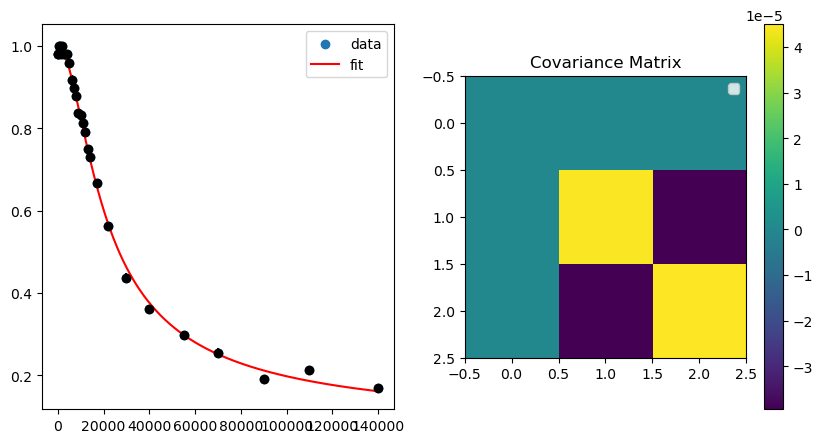

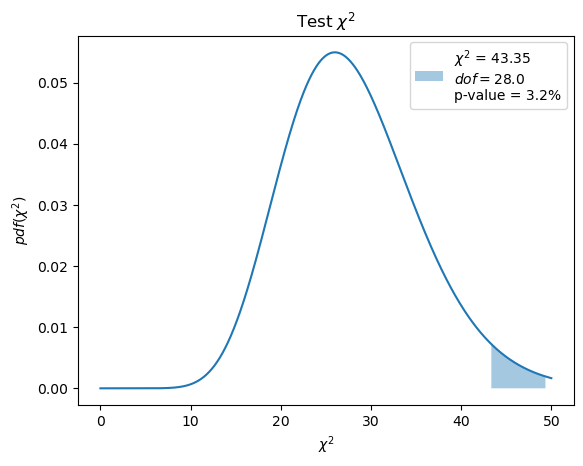

In [42]:
f = Fit(freqs, V_c_all, H_C, 0.01, kwargs={'tau':1e-3, 'a':0.07, 'b':1})
f.fit()
f.visualize(cov=True)
plt.legend()
print(f.values)
print(f.errors)
print("Chi2 = ",f.fval / f.ndof)
plt.show()
chi_test(f.fval, f.ndof, 50)
plt.show()

# RL

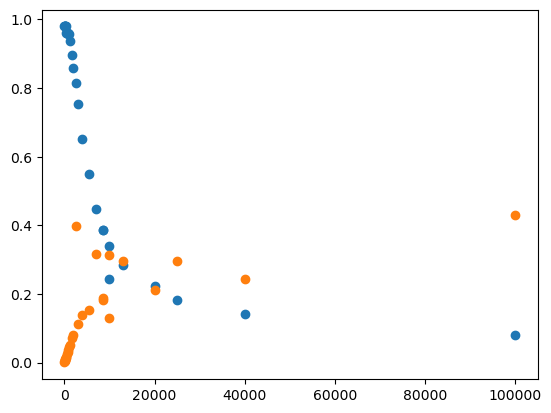

In [34]:
mods, fases, freqs = [], [], []

for i in os.listdir('data/RL'):
    path = 'data/RL/'+i+'/'
    V_res, V_c, dt_res, dt_c = analize(path, 300)
    mods.append(V_res)
    fases.append(dt_res*float(i))
    freqs.append(float(i))

plt.scatter(freqs,mods)
plt.scatter(freqs,fases)